# Implementation of different versions of the benefit difference fairness function

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import multiprocessing as mp
from src.util import sigmoid
from src.feature_map import IdentityFeatureMap
from src.functions import cost_utility, demographic_parity
from src.plotting import plot_mean_over_time, plot_median_over_time
from src.training import train
from src.distribution import SplitDistribution, UncalibratedScore

In [2]:
def fairness_function(**fairness_kwargs):
    policy = fairness_kwargs["policy"]
    x = fairness_kwargs["x"]
    s = fairness_kwargs["s"]
    y = fairness_kwargs["y"]
    decisions = fairness_kwargs["decisions"]
    ips_weights = fairness_kwargs["ips_weights"]
    phi, denominator_log_grad = policy._log_gradient(x, s)

    benefit = policy.benefit_function(decisions=decisions, y=y)
    benefit_gradient = benefit / denominator_log_grad

    if ips_weights is not None:
        benefit *= ips_weights
        benefit_gradient *= ips_weights

    benefit_grad = phi * benefit_gradient
        
    # benefit-difference * grad-benefit-difference
    return policy._mean_difference(benefit, s) * policy._mean_difference(benefit_grad, s)

## Uncalibrated Score

In [3]:
bias = True
dim_x = 1
dim_theta = dim_x + 1 if bias else dim_x

def util_func(**util_params):
    util = cost_utility(cost_factor=0.1, **util_params)
    return util

training_parameters = {    
    'save_path': "/home/fkretschmar/Documents/master-thesis/res/exp-006/uncalibrated/",
    'model':{
        'theta': [-3.0, 5.0],
        'benefit_value_function': demographic_parity,
        'utility_value_function': util_func,
        'fairness_function': fairness_function,
        'feature_map': IdentityFeatureMap(dim_theta),
        'keep_collected_data': False,
        'use_sensitve_attributes': False,
        'bias': bias
    },
    'optimization': {
        'time_steps':200,
        'epochs': 128,
        'batch_size':256,
        'learning_rate': 1,
        'decay_rate': 1,
        'decay_step': 10000
    },
    'data': {
        'distribution': UncalibratedScore(bias=bias),
        'keep_data_across_lambdas': True,
        'fraction_protected':0.5,
        'num_test_samples': 8192,
        'num_decisions': 128 * 256
    }
}


6 0.00069681 0.00052477 0.00054918 0.00190509 0.00216679
 0.00169204 0.00185235 0.00165148 0.00063185 0.00165131 0.00040737
 0.00185967 0.00049049 0.00120142 0.00144529 0.00051727 0.00112031
 0.00158862 0.00096228 0.0007762  0.00160514 0.00111765 0.0004394
 0.0016885  0.00084947 0.00049945 0.00108903 0.00094495 0.00040594
 0.00146055 0.00143926 0.00047432 0.00133371 0.00074424 0.0004696
 0.00200638 0.00064072 0.00048603 0.00041067 0.00137603 0.00039538
 0.00121233 0.00065718 0.00129751 0.00069152 0.00048061 0.00106642
 0.00150736 0.00223194 0.00243157 0.00236964 0.00228065 0.00241907
 0.00228997 0.00235608 0.00229518 0.00229481 0.00224412 0.0022211
 0.00224811 0.00230564 0.00231306 0.0026739  0.00167394 0.00186953
 0.00169648 0.00198525 0.00172223 0.00173821 0.00189896 0.0016981
 0.00166806 0.00188308 0.00186398 0.00167667 0.00170119 0.00164532
 0.00181158 0.00196868 0.00223008 0.0016955  0.00168353 0.00168567
 0.00167845 0.00223412 0.00164683 0.00177371 0.00166056 0.00165829
 0.001670

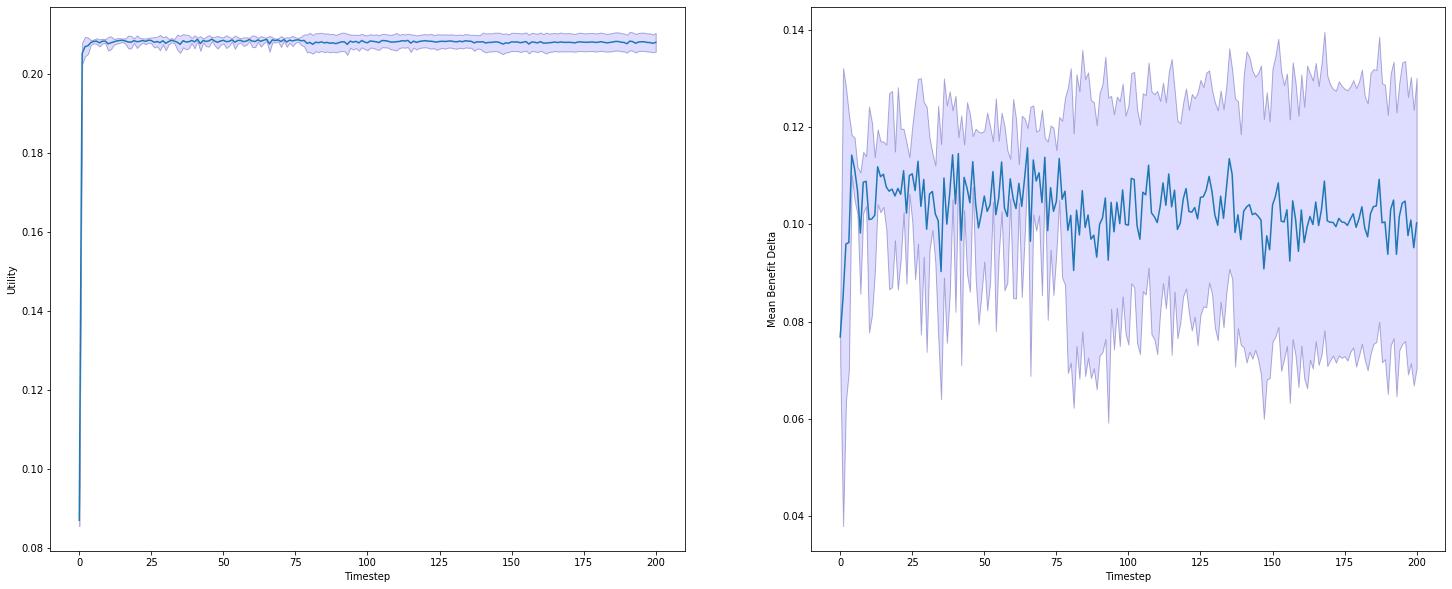

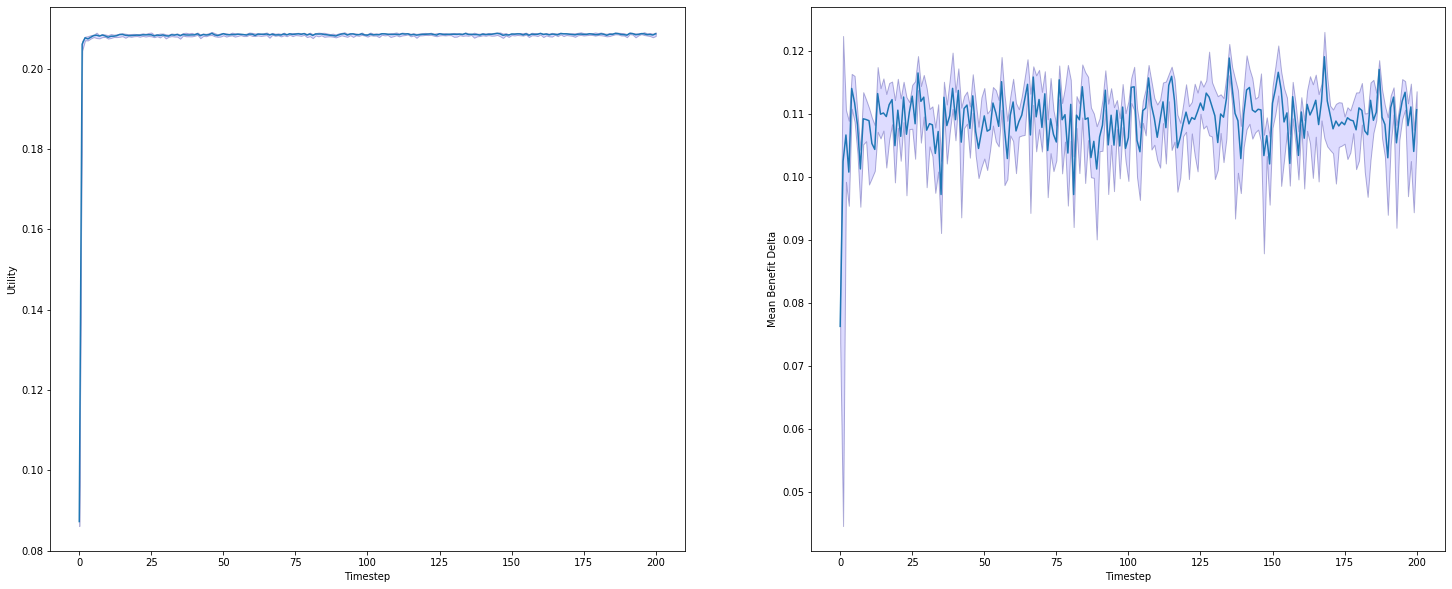

In [4]:
statistics, run_path = train(training_parameters, fairness_rates=[0.0], iterations=30, store_all=True, verbose=True, asynchronous=True)

plot_mean_over_time(statistics, "{}/results_mean.png".format(run_path))
plot_median_over_time(statistics, "{}/results_median.png".format(run_path))

## Split Distribution

In [7]:
bias = True
dim_x = 1
dim_theta = dim_x + 1 if bias else dim_x

def util_func(**util_params):
    util = cost_utility(cost_factor=0.55, **util_params)
    return util

training_parameters = {    
    'save_path': "/home/fkretschmar/Documents/master-thesis/res/exp-006/split/",
    'model':{
        'theta': [-3.5, 0.6],
        'benefit_value_function': demographic_parity,
        'utility_value_function': util_func,
        'fairness_function': fairness_function,
        'feature_map': IdentityFeatureMap(dim_theta),
        'keep_collected_data': False,
        'use_sensitve_attributes': False,
        'bias': bias
    },
    'optimization': {
        'time_steps':200,
        'epochs': 32,
        'batch_size':512,
        'learning_rate': 0.5,
        'decay_rate': 0.8,
        'decay_step': 30,
        'test_at_every_timestep': False
    },
    'data': {
        'distribution': SplitDistribution(bias=bias),
        'keep_data_across_lambdas': True,
        'fraction_protected':0.5,
        'num_test_samples': 20480,
        'num_decisions': 32 * 512
    }
}

8 0.01428991 0.01712365 0.01417482 0.0141647  0.01423533
 0.01444931 0.0142659  0.01425798 0.01423724 0.01431537 0.01429681
 0.01432582 0.01441808 0.01425214 0.01427341 0.014174   0.01428954
 0.0158992  0.01426822 0.01446468 0.01429352 0.0141738  0.01424712
 0.01425374 0.01423513 0.01414435 0.01416791 0.01434009 0.01435887
 0.01416697 0.01422408 0.01439012 0.01429017 0.01419118 0.01430641
 0.01422612 0.01434328 0.0143679  0.01419193 0.01426395 0.01424772
 0.01434289 0.01429948 0.01417947 0.01416612 0.01426823 0.01422125
 0.01421917 0.01427676 0.01427821 0.01421878 0.0143778  0.01439327
 0.01420307 0.01425804 0.01436645 0.01418539 0.01422296 0.01415164
 0.01425872 0.01428126 0.01417237 0.01416843 0.01422151 0.01425786
 0.01422622 0.01419159 0.0141797  0.01423825 0.01417566 0.01417856
 0.01416233 0.01420685 0.01441827 0.01434709 0.01423166 0.01424411
 0.0141605  0.01426656 0.01423273 0.01416809 0.01419682 0.01417552
 0.01420143 0.0141383  0.01431755 0.01429665 0.01430058 0.01421887
 0.01

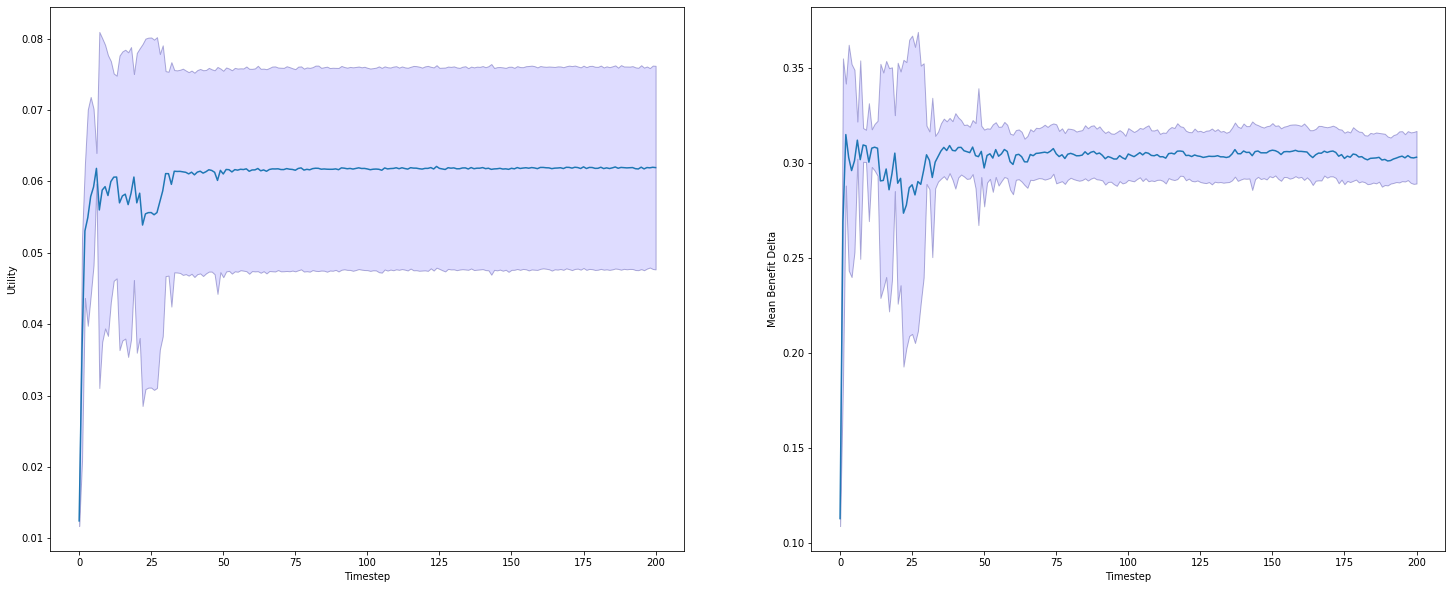

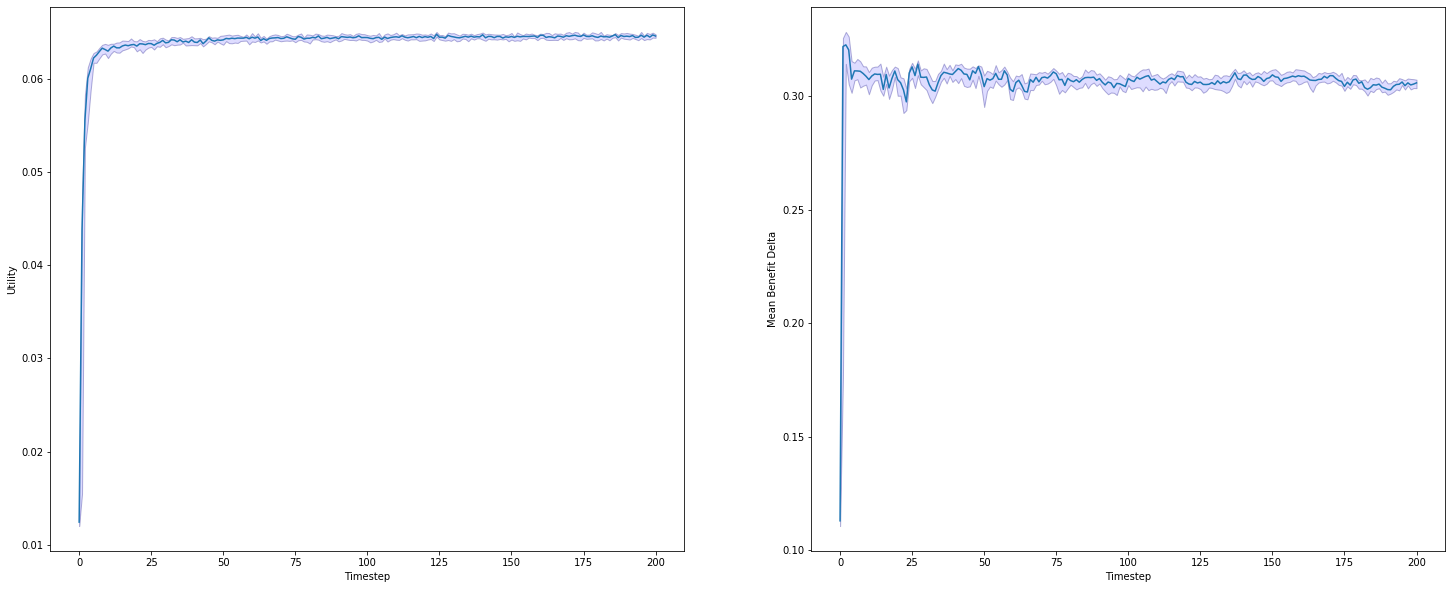

In [9]:
statistics, run_path = train(training_parameters, fairness_rates=[0.0], iterations=30, store_all=True, verbose=True, asynchronous=True)

plot_mean_over_time(statistics, "{}/results_mean.png".format(run_path))
plot_median_over_time(statistics, "{}/results_median.png".format(run_path))